In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [2]:
from hydra.utils import to_absolute_path

In [3]:
import numpy as np

In [6]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger,epoch_load):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
            overlap = self.sequence_length
        )
        print(len(self.dataset))
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
            epoch=epoch_load
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        for sequence in self.dataloader:
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

                predict.append(h_u_v_i_1_pred)
                # Denormalize ground truth from next_graph
                groundtruth.append(self._denormalize_data(
                    next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                ))
            break
        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [7]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

import time 
epochs = [500,600,700,800,900,1000,1100,1200,1300,1400]
horyzon = [1,2,3,4,5,6,7,8,9]
result = np.zeros((len(epochs),30))
result_csi = np.zeros((len(epochs),30))
def calculate_csi(predictions, observations, epsilon):
    """
    Calcule le Critical Success Index (CSI) entre deux tableaux de prédictions et d'observations.
    
    Parameters:
    predictions (numpy.ndarray): Un tableau numpy contenant les prédictions.
    observations (numpy.ndarray): Un tableau numpy contenant les observations réelles.
    epsilon (float): Le seuil pour déterminer les valeurs binaires (0 ou 1).
    
    Returns:
    float: Le Critical Success Index (CSI).
    """
    
    # Binariser les prédictions et les observations selon le seuil epsilon
    binary_predictions = (predictions >= epsilon).astype(int)
    binary_observations = (observations >= epsilon).astype(int)
    
    # Calculer les True Positives, False Positives et False Negatives
    TP = np.sum((binary_predictions == 1) & (binary_observations == 1))
    FP = np.sum((binary_predictions == 1) & (binary_observations == 0))
    FN = np.sum((binary_predictions == 0) & (binary_observations == 1))
    
    # Calculer le CSI
    csi = TP / (TP + FP + FN)
    
    return csi
# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="Config1Group3Test")
    
    # Display the configuration (optional)
    print(OmegaConf.to_yaml(cfg))
    
    for j,epoch in enumerate(epochs):
        # Now call the training function with the composed config
        test = TestRollout(cfg,logger,epoch)
        predict,groundtruth,origin = test.predict_unroll(unroll_steps=30)
        print(len(groundtruth))
        L1_list= []
        CSI_list=[]
        for pdt in range(len(groundtruth)) :
            gd = groundtruth[pdt]
            pred = predict[pdt]
            L1_list.append(np.mean(np.abs(gd-pred)))
            CSI_list.append(calculate_csi(gd,pred,5e-2))
        result[j,:] = np.array(L1_list)
        result_csi[j,:]= np.array(CSI_list)

/tmp/ipykernel_6429/168763428.py:37: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[15:04:38 - main - INFO] Using cuda device


data_dir: /work/m24046/m24046mrcr/results_data_30min/Multimesh_2_32_True.bin
dynamic_dir:
- /work/m24046/m24046mrcr/results_data_30min/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl
batch_size: 1
epochs: 501
mp_layers: 10
lr: 0.0005
lr_decay_rate: 0.999995
num_input_features: 9
num_output_features: 3
num_edge_features: 3
custom_loss: false
sequence_length: 31
use_apex: true
amp: true
jit: false
num_dataloader_workers: 1
do_concat_trick: true
num_processor_checkpoint_segments: 0
recompute_activation: false
ckpt_path: /work/m24046/m24046mrcr/new_tests_Group3/config1

Loading normalization statistics...


[15:04:50 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1/MeshGraphNet.0.500.mdlus to device cuda
[15:04:50 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1/checkpoint.0.500.pt to device cuda


50
DataLoader Length: 50
30


[15:05:02 - main - INFO] Using cuda device


Loading normalization statistics...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6429/168763428.py", line 48, in <module>
    test = TestRollout(cfg,logger,epoch)
  File "/tmp/ipykernel_6429/1442944589.py", line 25, in __init__
    self.dataset = TelemacDataset(
  File "/users/m24046/m24046mrcr/gnn_modulus_test/python/create_dgl_dataset.py", line 827, in __init__
    self._normalize_data(self.node_stats, self.edge_stats, self.node_var_info, self.edge_var_info)
  File "/users/m24046/m24046mrcr/gnn_modulus_test/python/create_dgl_dataset.py", line -1, in _normalize_data
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  Fi

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=400)
plt.title("Evolution de l'erreur L1 sur la hauteur d'eau en fonction en fonction de l'horizon d'entrainement")
for i,name in enumerate(epochs):
    plt.plot(result[i,:],label=str("Epochs : {}".format(epochs[i])))
plt.legend()
plt.xlabel("nombre de pas de temps")
plt.ylabel("erreur L1 sur la hauteur d'eau")
plt.show()

In [10]:
nb_cellules_mouille = []
for gd in groundtruth : 
    hauteur = gd[:,0]
    nb_cellules_mouille.append(sum(hauteur>0.05))

amin, amax = min(nb_cellules_mouille), max(nb_cellules_mouille)
for i, val in enumerate(nb_cellules_mouille):
    nb_cellules_mouille[i] = (val-amin) / (amax-amin)

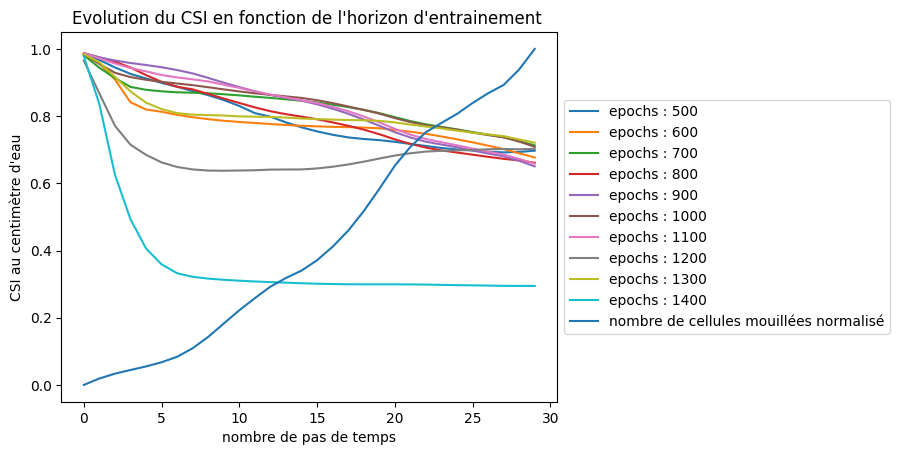

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Evolution du CSI en fonction de l'horizon d'entrainement ")
for i,name in enumerate(epochs):
    plt.plot(result_csi[i,:],label=str("epochs : {}".format(epochs[i])))

plt.plot(nb_cellules_mouille,label="nombre de cellules mouillées normalisé")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("nombre de pas de temps")
plt.ylabel("CSI au centimètre d'eau")
plt.show()